# 任务描述

近年来，随着人工智能的发展，其在语音识别、自然语言处理、图像与视频分析等诸多领域取得了巨大成功。随着政府对环境保护的呼吁，垃圾分类成为一个亟待解决的问题，本次竞赛将聚焦在垃圾图片的分类，利用人工智能技术，对居民生活垃圾图片进行检测，找出图片中有哪些类别的垃圾。 要求参赛者给出一个算法或模型，对于给定的图片，检测出图片中的垃圾类别。给定图片数据，选手据此训练模型，为每张测试数据预测出最正确的类别。

# 数据说明

本竞赛所用训练和测试图片均来自生活场景。总共四十个类别，类别和标签对应关系在训练集中的dict文件里。图片中垃圾的类别，格式是“一级类别/二级类别”，二级类别是具体的垃圾物体类别，也就是训练数据中标注的类别，比如一次性快餐盒、果皮果肉、旧衣服等。一级类别有四种类别：可回收物、厨余垃圾、有害垃圾和其他垃圾。 数据文件包括训练集(有标注)和测试集(无标注)，训练集的所有图片分别保存在train文件夹下面的0-39个文件夹中，文件名即类别标签，测试集共有400张待分类的垃圾图片在test文件夹下，testpath.txt保存了所有测试集文件的名称，格式为：name+\n。
![](https://ai-studio-static-online.cdn.bcebos.com/514a5887b4c64fa5bdae491a033bc448eff52ea1a39c4ea2ae79a7373b58d6e9)
![](https://ai-studio-static-online.cdn.bcebos.com/6e73a1d506b94362bd26ad99badf91df5a2d3b48d7864c529d022a5bf188d0e8)


# 提交答案

考试提交，需要提交模型代码项目版本和结果文件。结果文件为TXT文件格式，命名为result.txt，文件内的字段需要按照指定格式写入。 提交结果的格式如下：

每一行为：图像名 标签 test1.jpg 29
输出结果应检查是否为400行数据，否则成绩无效。
.输出结果文件命名为result.txt，一行一个数据。
样例如下：

···     
test2.jpg 1         
test3.jpg 4     
test4.jpg 23    
test5.jpg 5     
test6.jpg 0     
test7.jpg 1     
test8.jpg 31        
test9.jpg 33    
test10.jpg 34   
test11.jpg 31 

···    


**STEP1数据准备**

In [1]:
import zipfile

def unzip_file(zip_file_path, extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

zip_file_path = '/home/aistudio/data/data126282/train.zip'
extract_path = '/home/aistudio/mymymy'
unzip_file(zip_file_path, extract_path)

In [2]:
!pip install imgaug
!pip install ppim
!pip install pptb==0.1.8

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 20.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 26.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 37.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=cc9dc99c0fbce4847a463584b3750d3bb7a0cf5fa35d987195db243a487abd10
  Stored in directory: /home/aistudio/.cache/pip/wheels/dc/31/7f/a4a4

In [3]:
# 导入必要的包
import json
import os
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug
import imgaug.augmenters as iaa
import paddle
import paddle.nn.functional as F
import ppim
import pptb.vision.models as ppmodels
import PIL.Image as Image
import matplotlib.pyplot as plt
from paddle.io import Dataset
from pptb.nn import LabelSmoothingLoss
from pptb.optimizer.lr import CosineWarmup
from pptb.tools import MixingDataController
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

W0618 18:36:52.939007   233 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0618 18:36:52.945420   233 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [4]:
!unzip data/data*/train.zip -d data/dataset
!unzip data/data*/test.zip -d data/dataset

  inflating: data/dataset/train/25/img_12549.jpg  
  inflating: data/dataset/train/25/img_12788.jpg  
  inflating: data/dataset/train/25/img_12763.jpg  
  inflating: data/dataset/train/25/img_12777.jpg  
  inflating: data/dataset/train/25/img_12165.jpg  
  inflating: data/dataset/train/25/img_12159.jpg  
  inflating: data/dataset/train/25/img_12415.jpg  
  inflating: data/dataset/train/25/img_12429.jpg  
  inflating: data/dataset/train/25/img_12428.jpg  
  inflating: data/dataset/train/25/img_12372.jpg  
  inflating: data/dataset/train/25/img_12399.jpg  
  inflating: data/dataset/train/25/img_12164.jpg  
  inflating: data/dataset/train/25/img_12170.jpg  
  inflating: data/dataset/train/25/img_12616.jpg  
  inflating: data/dataset/train/25/img_12776.jpg  
  inflating: data/dataset/train/25/img_12762.jpg  
  inflating: data/dataset/train/25/img_12789.jpg  
  inflating: data/dataset/train/25/img_12548.jpg  
  inflating: data/dataset/train/25/img_12560.jpg  
  inflating: data/dataset/train

In [5]:
# 超参数设置
LEARNING_RATE = 0.0003
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 64
WARMUP_EPOCHS = 3
NUM_EPOCHS = 50
print(LEARNING_RATE,TRAIN_BATCH_SIZE,NUM_EPOCHS)

0.0003 32 50


In [6]:
TRAIN_DATA_DIR = "data/dataset/train"
TEST_DATA_DIR = "data/dataset/test"
TEST_DATA_PATH_LIST = "data/dataset/testpath.txt"
TRAIN_LIST_PATH = "data/dataset/train.txt"
VALID_LIST_PATH = "data/dataset/valid.txt"
DESCRIPTION_FILE_PATH = "data/dataset/garbage_dict.json"
RESULTS_FILE_PATH = "/home/aistudio/work/results.txt"
MODEL_CKPT_DIR = "data/ckpt/"

TEST_SET_SIZE = 400
SAVE_STEPS = 250
LOG_STEPS = 20

# Image size
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNEL = 3

NUM_CLASSES = 40

# Tricks
MIXUP_PROB = .4   # Mixup 技巧的概率
MIXUP_ALPHA = .2   # Mixup 技巧的超参数 alpha
CUTMIX_PROB = .4   # CutMix 技巧的概率
CUTMIX_ALPHA = .2   # CutMix 技巧的超参数 alpha
USE_LABEL_SMOOTH = True   # 是否使用标签平滑技巧
LABEL_SMOOTH_EPISION = .1   # 标签平滑技巧的超参数 epsilon
USE_AMP = True   # 是否使用自动混合精度训练
FREEZE_PROP = .8   #冻结特征提取层的比例



In [7]:
def divide_train_valid_list(src_dir, train_list_path, valid_list_path, train_prop=0.8, seed=0):
    labels = []
    img_path_list = []
    np.random.seed(seed)
    
    for label in os.listdir(src_dir):
        label_dir = os.path.join(src_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(src_dir, label, img_name)
            img_path_list.append(img_path)
            labels.append(label)

    assert len(labels) == len(img_path_list)
    dataset_size = len(labels)
    permutation = np.random.permutation(dataset_size)
    train_size = int(dataset_size * train_prop)
    valid_size = dataset_size - train_size

    print(f"Dataset size: {dataset_size}; Training set size: {train_size}; Evalset size: {valid_size}.")
    with open(train_list_path, 'w') as f_train, open(valid_list_path, 'w') as f_valid:
        for n, idx in enumerate(permutation):
            img_path = img_path_list[idx]
            label = labels[idx]
            if n < train_size:
                f_train.write(img_path + ' ' + label + '\n')
            else:
                f_valid.write(img_path + ' ' + label + '\n')

In [8]:
divide_train_valid_list(TRAIN_DATA_DIR, TRAIN_LIST_PATH, VALID_LIST_PATH, train_prop=0.9)

Dataset size: 14402; Training set size: 12961; Evalset size: 1441.


In [9]:
class ImgAugument(paddle.vision.transforms.BaseTransform):
    def __init__(self):
        super().__init__()
        self.augmentations = iaa.Sequential([
            iaa.Sometimes(
                0.3,
                iaa.OneOf([
                    iaa.Dropout(p=(0, 0.05), per_channel=0.5),
                    iaa.Cutout(fill_mode="gaussian", fill_per_channel=True),
                    iaa.CoarseDropout(0.02, size_percent=0.15, per_channel=0.5)
                ])
            ),
            iaa.OneOf([
                iaa.Identity(),
                iaa.Sharpen((0.0, 0.1)),
            ]),
            iaa.OneOf([
                iaa.Identity(),
                iaa.Affine(
                    rotate=(-8, 8),
                    translate_percent=(-0.1, 0.1),
                    scale=(0.9, 1.1),
                    cval=(200, 255)
                ),
                iaa.CropAndPad(
                    percent=(-0.05, 0.05),
                    pad_mode=imgaug.ALL,
                    pad_cval=(200, 255)
                ),
            ]),
            iaa.SomeOf((0, 3),[
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.Multiply((0.9, 1.1), per_channel=0.5),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                iaa.AddToBrightness((-10, 10)),
                iaa.AddToHue((-10, 10)),
            ]),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.05),
            iaa.OneOf([
                iaa.Identity(),
                iaa.GaussianBlur((0, 3.0)),
                iaa.AverageBlur(k=(2, 7)),
                iaa.MedianBlur(k=(3, 11)),
            ]),
        ], random_order=True)

    def _apply_image(self, img):
        return self.augmentations(image=img)


TRANSFORM_DEFAULT = paddle.vision.transforms.Compose([
    paddle.vision.transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    paddle.vision.transforms.Normalize(
        mean=[0., 0., 0.],
        std=[255., 255., 255.],
        data_format="HWC",
    ),
    paddle.vision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        data_format="HWC",
    ),
    paddle.vision.transforms.Transpose()
])

TRANSFORM_AUGUMENTED = paddle.vision.transforms.Compose([
    ImgAugument(),
    TRANSFORM_DEFAULT,
])

class ImgTestAugmentionFliplr(paddle.vision.transforms.BaseTransform):
    def __init__(self):
        super().__init__()
        self.augmentations = iaa.Fliplr(1)

    def _apply_image(self, img):
        return self.augmentations(image=img)

class ImgTestAugmentionFlipud(paddle.vision.transforms.BaseTransform):
    def __init__(self):
        super().__init__()
        self.augmentations = iaa.Flipud(1)

    def _apply_image(self, img):
        return self.augmentations(image=img)

class ImgTestAugmentionSharpen(paddle.vision.transforms.BaseTransform):
    def __init__(self):
        super().__init__()
        self.augmentations = iaa.Sharpen(0.1)

    def _apply_image(self, img):
        return self.augmentations(image=img)

class ImgTestAugmentionRot90(paddle.vision.transforms.BaseTransform):
    def __init__(self, k=1):
        super().__init__()
        self.augmentations = iaa.Rot90(k)

    def _apply_image(self, img):
        return self.augmentations(image=img)

TRANSFORM_TEST_AUG_FLIPLR = paddle.vision.transforms.Compose([
    ImgTestAugmentionFliplr(),
    TRANSFORM_DEFAULT,
])

TRANSFORM_TEST_AUG_FLIPUD = paddle.vision.transforms.Compose([
    ImgTestAugmentionFlipud(),
    TRANSFORM_DEFAULT,
])

TRANSFORM_TEST_AUG_SHARPEN = paddle.vision.transforms.Compose([
    ImgTestAugmentionSharpen(),
    TRANSFORM_DEFAULT,
])

TRANSFORM_TEST_AUG_ROT_90 = paddle.vision.transforms.Compose([
    ImgTestAugmentionRot90(k=1),
    TRANSFORM_DEFAULT,
])

TRANSFORM_TEST_AUG_ROT_270 = paddle.vision.transforms.Compose([
    ImgTestAugmentionRot90(k=3),
    TRANSFORM_DEFAULT,
])



In [10]:

def read_img(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB') 
    return np.array(img)

def label_map(label):
    with open(DESCRIPTION_FILE_PATH, 'r') as f:
        description = json.load(f)
    return description[label]

'''
with open(TRAIN_LIST_PATH, 'r') as f:
    img_path, label = f.readline().rstrip().split(' ')
    img = read_img(img_path)
    print(label_map(label))
    plt.imshow(img)
'''

"\nwith open(TRAIN_LIST_PATH, 'r') as f:\n    img_path, label = f.readline().rstrip().split(' ')\n    img = read_img(img_path)\n    print(label_map(label))\n    plt.imshow(img)\n"

In [11]:
class GarbageDataset(Dataset):
    def __init__(self, data_list_path, transform):
        super().__init__()
        self.data_list_path = data_list_path
        self.transform = transform
        self.img_path_list = []
        self.labels = []

        with open(data_list_path, "r") as f:
            for line in f:
                line = line.rstrip().split(' ')
                if not line:
                    continue
                img_path, label = line
                self.img_path_list.append(img_path)
                self.labels.append(int(label))
        
        assert len(self.img_path_list) == len(self.labels)

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = np.array(img)
        img = self.transform(img)
        img = img.astype(np.float32)
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def __len__(self):
        return len(self.img_path_list)


class GarbageTestDataset(Dataset):
    def __init__(self, data_dir, data_list_path, transform_list):
        super().__init__()
        self.data_dir = data_dir
        self.data_list_path = data_list_path
        self.transform_list = transform_list
        self.img_path_list = []

        with open(data_list_path, "r") as f:
            for line in f:
                line = line.rstrip()
                if not line:
                    continue
                img_name = line
                img_path = os.path.join(self.data_dir, img_name)
                self.img_path_list.append(img_path)

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = np.array(img)
        img_transformed_list = [transform(img) for transform in self.transform_list]
        img_transformed_list = [img.astype(np.float32) for img in img_transformed_list]
        return img_transformed_list

    def __len__(self):
        return len(self.img_path_list)



In [12]:

train_set = GarbageDataset(TRAIN_LIST_PATH, transform=TRANSFORM_AUGUMENTED)
valid_set = GarbageDataset(VALID_LIST_PATH, transform=TRANSFORM_DEFAULT)
test_set = GarbageTestDataset(TEST_DATA_DIR, TEST_DATA_PATH_LIST, transform_list=[TRANSFORM_DEFAULT])
train_loader = paddle.io.DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE, 
    shuffle=True,
    drop_last=True,
    num_workers=4,
    use_shared_memory=False,
)
valid_loader = paddle.io.DataLoader(
    valid_set, 
    batch_size=EVAL_BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    use_shared_memory=False,
)
test_loader = paddle.io.DataLoader(test_set, batch_size=EVAL_BATCH_SIZE, shuffle=False)

'''
img, label = train_set[99]
print(img.shape, label_map(str(label[0])))
print(img.max(), img.min())
print(type(img))
plt.imshow((255 * (img.transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))).astype('uint8'))
'''

"\nimg, label = train_set[99]\nprint(img.shape, label_map(str(label[0])))\nprint(img.max(), img.min())\nprint(type(img))\nplt.imshow((255 * (img.transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))).astype('uint8'))\n"

**STEP2模型设计**

In [13]:
class VIT(paddle.nn.Layer):
    def __init__(self, num_classes=1, freeze_prop=.9):
        super().__init__()
        self.backbone = ppim.swin_b(pretrained=True, class_dim=num_classes)
        self.freeze_params(freeze_prop)

    def freeze_params(self, freeze_prop):
        total_params_size = sum([np.prod(param.shape) for param in self.backbone.parameters()])
        curr_params_size = 0
        for param in self.backbone.parameters():
            curr_params_size += np.prod(param.shape)
            if curr_params_size < int(freeze_prop * total_params_size):
                param.trainable = False
            else:
                break

    def forward(self, x):
        x = self.backbone(x)
        return x

def model_forward(model, X_batch, y_batch, mixing_data_controller):
    assert X_batch.shape[2] == IMG_HEIGHT
    assert X_batch.shape[3] == IMG_WIDTH
    X_batch_mixed, y_batch_a, y_batch_b, lam = mixing_data_controller.mix(X_batch, y_batch)
    predicts = model(X_batch_mixed)
    loss = mixing_data_controller.loss(predicts, y_batch_a, y_batch_b, lam)
    acc = mixing_data_controller.metric(predicts, y_batch_a, y_batch_b, lam)
    return loss, acc



**STEP3训练配置**

In [14]:
input_spec = paddle.static.InputSpec(
        shape=[-1, IMG_CHANNEL, IMG_HEIGHT, IMG_WIDTH],
        dtype="float32",
        name="img"
)

label_spec = paddle.static.InputSpec(
        shape=[-1, 1],
        dtype="int64",
        name="label"
)

model = VIT(num_classes=NUM_CLASSES, freeze_prop=FREEZE_PROP)

paddle.summary(model, input_spec)



100%|██████████| 344410/344410 [00:12<00:00, 28581.52it/s]


-----------------------------------------------------------------------------------
     Layer (type)           Input Shape          Output Shape         Param #    
       Conv2D-5          [[1, 3, 224, 224]]    [1, 128, 56, 56]        6,272     
      LayerNorm-1         [[1, 3136, 128]]      [1, 3136, 128]          256      
     PatchEmbed-1        [[1, 3, 224, 224]]     [1, 3136, 128]           0       
       Dropout-1          [[1, 3136, 128]]      [1, 3136, 128]           0       
      LayerNorm-2         [[1, 3136, 128]]      [1, 3136, 128]          256      
       Linear-1           [[64, 49, 128]]       [64, 49, 384]         49,536     
       Softmax-1         [[64, 4, 49, 49]]     [64, 4, 49, 49]           0       
       Dropout-2         [[64, 4, 49, 49]]     [64, 4, 49, 49]           0       
       Linear-2           [[64, 49, 128]]       [64, 49, 128]         16,512     
       Dropout-3          [[64, 49, 128]]       [64, 49, 128]            0       
   WindowAtten

{'total_params': 86784224, 'trainable_params': 21038408}

In [15]:
loss_function = paddle.nn.CrossEntropyLoss()
if USE_LABEL_SMOOTH:
    loss_function = LabelSmoothingLoss(paddle.nn.CrossEntropyLoss(soft_label=True), NUM_CLASSES, LABEL_SMOOTH_EPISION)
step_each_epoch = len(train_set) // TRAIN_BATCH_SIZE
lr_scheduler = CosineWarmup(
    LEARNING_RATE,
    total_steps = NUM_EPOCHS * step_each_epoch,
    warmup_steps = WARMUP_EPOCHS * step_each_epoch,
    warmup_start_lr = 0.0,
    cosine_end_lr = 0.0,
    last_epoch = -1
)
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters()
)
mixing_data_controller = MixingDataController(
    mixup_prob=MIXUP_PROB,
    cutmix_prob=CUTMIX_PROB,
    mixup_alpha=MIXUP_ALPHA,
    cutmix_alpha=CUTMIX_ALPHA,
    cutmix_axes=[2, 3],
    loss_function=loss_function,
    metric_function=paddle.metric.accuracy,
)
if USE_AMP:
    amp_scaler = paddle.amp.GradScaler(init_loss_scaling=2.0**16,
                                    incr_every_n_steps=2000,
                                    decr_every_n_nan_or_inf=1)





**STEP4&5训练过程和模型保存**

In [16]:
history = {
    "accuracy": {
        "train": [],
        "valid": [],
    },
    "loss": {
        "train": [],
        "valid": []
    },
    "lr": []
}                        
steps = 0
best_score = .0
best_ckpt = 0
for epoch_idx in range(1, NUM_EPOCHS+1):
    accuracy_recorder = {'train': [], 'valid': []}
    loss_recorder = {'train': [], 'valid': []}

    # 训练模型
    model.train()
    for _, (X_batch, y_batch) in enumerate(train_loader()):
        steps += 1
        
        if USE_AMP:
            with paddle.amp.auto_cast(custom_black_list={"reduce_mean"}):
                loss, acc = model_forward(model, X_batch, y_batch, mixing_data_controller)

            loss_scaled = amp_scaler.scale(loss)
            loss_scaled.backward()
            # keep prior to 2.0 design
            amp_scaler.minimize(optimizer, loss_scaled)
            optimizer.clear_grad()
            lr_scheduler.step()
        else:
            # 前向传播
            loss, acc = model_forward(model, X_batch, y_batch, mixing_data_controller)

            # 反向传播、lr decay
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            lr_scheduler.step()

        accuracy_recorder['train'].append(acc.numpy())
        loss_recorder['train'].append(loss.numpy())

        if steps % LOG_STEPS == 0:
            print(f'[Training] Epoch: {epoch_idx}, step: {steps}, loss is: {loss.numpy()[0]}, acc is: {acc.numpy()[0]:.2%}    ', end='\r')

        if steps % SAVE_STEPS == 0:
            save_path = os.path.join(MODEL_CKPT_DIR, f"ckpt_{steps}.pdparams")
            print(f"[Save] save model to: {save_path}                                     ")
            paddle.save(model.state_dict(), save_path)

    # eval set: acc loss
    model.eval()
    for i, (x_data, y_data) in enumerate(valid_loader()):
        predicts = model(x_data)
        loss = loss_function(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)

        if i % LOG_STEPS == 0:
            print(f'[Testing] Epoch: {epoch_idx}, step: {steps}, loss is: {loss.numpy()[0]}, acc is: {acc.numpy()[0]:.2%}   ', end='\r')

        accuracy_recorder['valid'].append(acc.numpy())
        loss_recorder['valid'].append(loss.numpy())
    
    now = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print(f'''\
Epoch: {epoch_idx}/{NUM_EPOCHS}, step: {steps}, lr: {lr_scheduler():.6f} @{now}                                                                          
    train loss is: {np.mean(loss_recorder["train"])}, train acc is: {np.mean(accuracy_recorder["train"]):.2%}
    valid loss is: {np.mean(loss_recorder["valid"])}, valid acc is: {np.mean(accuracy_recorder["valid"]):.2%}''')

    # best
    score = np.mean(accuracy_recorder["valid"])
    if score > best_score:
        best_score = score
        best_ckpt = steps
        print(f"[Save] save best model ({steps} - {score})                          ")
        paddle.save(model.state_dict(), os.path.join(MODEL_CKPT_DIR, "best.pdparams"))

    # record loss and accuracy
    history["loss"]["train"].append(np.mean(loss_recorder["train"]))
    history["loss"]["valid"].append(np.mean(loss_recorder["valid"]))
    history["accuracy"]["train"].append(np.mean(accuracy_recorder["train"]))
    history["accuracy"]["valid"].append(np.mean(accuracy_recorder["valid"]))
    history["lr"].append(lr_scheduler())

paddle.save(model.state_dict(), os.path.join(MODEL_CKPT_DIR, "final.pdparams"))



[Training] Epoch: 1, step: 20, loss is: 3.697679042816162, acc is: 2.84%    
[Save] save model to: data/ckpt/ckpt_250.pdparams                                     
Epoch: 1/50, step: 405, lr: 0.000100 @2023-06-18 18:40:37                                                                          
    train loss is: 2.7593255043029785, train acc is: 38.81%
    valid loss is: 1.225509762763977, valid acc is: 83.18%
[Save] save best model (405 - 0.831768810749054)                          
[Save] save model to: data/ckpt/ckpt_500.pdparams                                     
[Save] save model to: data/ckpt/ckpt_750.pdparams                                     
Epoch: 2/50, step: 810, lr: 0.000200 @2023-06-18 18:43:52                                                                          
    train loss is: 1.6095962524414062, train acc is: 71.07%
    valid loss is: 1.0706031322479248, valid acc is: 87.11%
[Save] save best model (810 - 0.8711297512054443)                          
[Save] s

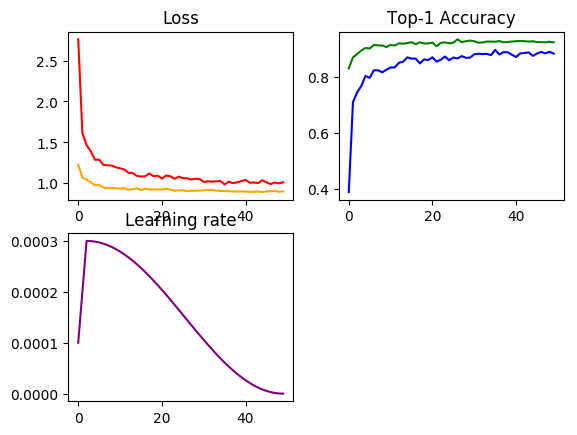

In [17]:
# training

x = np.arange(len(history["loss"]["train"]))

plt.subplot(2, 2, 1)
plt.title("Loss")
plt.plot(x, history["loss"]["train"], color="red", label="train")
plt.plot(x, history["loss"]["valid"], color="orange", label="valid")

plt.subplot(2, 2, 2)
plt.title("Top-1 Accuracy")
plt.plot(x, history["accuracy"]["train"], color="blue", label="train")
plt.plot(x, history["accuracy"]["valid"], color="green", label="valid")

plt.subplot(2, 2, 3)
plt.title("Learning rate")
plt.plot(x, history["lr"], color='purple')

**STEP6模型评估**

In [18]:
ensemble_models = ['data/ckpt/best.pdparams']
print(f"best model : step {best_ckpt}, accuracy {best_score}.")
!cp data/ckpt/best.pdparams work/

model.eval()
results = np.empty(TEST_SET_SIZE, dtype=np.uint8)
RESULTS_FILE_PATH = "/home/aistudio/work/results.txt"

idx = 0
with open(RESULTS_FILE_PATH, "w") as f:
    for images_auglist in test_loader():
        # Multiple model ensemble
        batch_len = images_auglist[0].shape[0]
        predict_ensemble = paddle.empty((len(ensemble_models) * len(images_auglist), batch_len, NUM_CLASSES), dtype=paddle.float32)
        for i, model_path in enumerate(ensemble_models):
            model.set_state_dict(paddle.load(model_path))
            model.eval()
            # Multiple augmentation testing
            for j, images in enumerate(images_auglist):
                predict = model(images)
                predict = paddle.nn.functional.softmax(predict)
                predict_ensemble[i*len(images_auglist)+j, ...] = predict

        predict_ensemble_squeezed = paddle.max(predict_ensemble, axis=0)
        result = paddle.argmax(predict_ensemble_squeezed, axis=1).numpy()

        for r in result:
            f.write(f"test{idx+1}.jpg\t{r}\n")
            idx += 1

print("Results written to file.")



best model : step 10935, accuracy 0.93618243932724.
Results written to file.


其他垃圾/一次性快餐盒


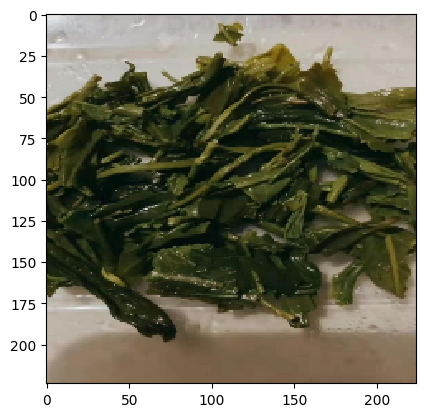

In [35]:
# 泛化能力测试
idx = np.random.randint(TEST_SET_SIZE)
image = test_set[idx][0]
image_tensor = paddle.to_tensor(np.expand_dims(image, 0))
predict = results[idx]
print(label_map(str(predict)))
plt.imshow((255 * (image.transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))).astype('uint8'))

In [20]:
# 分类报告

model.eval()
true_labels = []
predicted_labels = []

for i, (x_data, y_data) in enumerate(valid_loader()):
#for i, (x_data, y_data) in enumerate(test_loader()):
    predicts = model(x_data)
    loss = loss_function(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)

    if i % LOG_STEPS == 0:
        print(f'[Testing] Epoch: {epoch_idx}, step: {steps}, loss is: {loss.numpy()[0]}, acc is: {acc.numpy()[0]:.2%}   ', end='\r')

    accuracy_recorder['valid'].append(acc.numpy())
    loss_recorder['valid'].append(loss.numpy())

    true_labels.extend(y_data.numpy())
    predicted_labels.extend(paddle.argmax(predicts, axis=1).numpy())

report = classification_report(true_labels, predicted_labels, digits=7)
print(report)

[Testing] Epoch: 50, step: 20250, loss is: 0.9087979197502136, acc is: 92.19%   
              precision    recall  f1-score   support80148315, acc is: 95.31%   

           0  0.8571429 0.6000000 0.7058824        20
           1  1.0000000 1.0000000 1.0000000        34
           2  0.9666667 1.0000000 0.9830508        29
           3  0.8888889 0.8888889 0.8888889         9
           4  0.8888889 0.9411765 0.9142857        34
           5  0.9310345 0.9642857 0.9473684        28
           6  0.9230769 0.9729730 0.9473684        37
           7  0.9705882 1.0000000 0.9850746        33
           8  0.9000000 0.7941176 0.8437500        34
           9  0.9090909 0.8510638 0.8791209        47
          10  0.9473684 0.9729730 0.9600000        37
          11  0.9404762 0.9753086 0.9575758        81
          12  0.8611111 0.9393939 0.8985507        33
          13  0.9024390 1.0000000 0.9487179        37
          14  0.8484848 1.0000000 0.9180328        28
          15  0.9772727 0.9

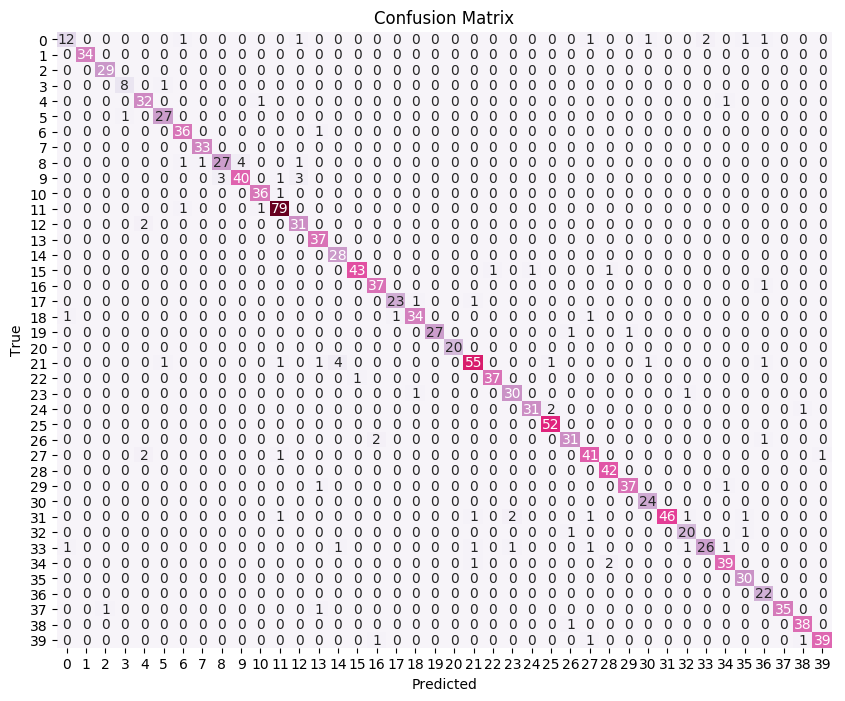

In [21]:
# 绘制混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()